# FNS-duct Benchmark Experiment

### Introduction

In this benchmark experiment a DT neutron source is placed at the center of a room. one of the walls in the room have an opening. In that opening a shielding stream assembly mostly made of iron is placed. In the stream assembly there is a dogleg duct. Around 10 detector sets are placed in different positions all along the duct and behid the stream assembly. Detectors are:
- Nb93(n,2n)Nb92 activation foil
- In115(n,n')In115 activation foil
- Au197(n,γ)Au198 activation foil
- Ne213 liquid organic scintillation spectrometer

Not all the detectors have been placed in all the 10 positions available.

### Experiment mockup (Morimoto et al. 2004):

<div>
<img src="fns_mockup.png" width="500"/>
</div>

### Source

The DT neutron source has a strong anisotropic distribution. Both energy spectrum and neutron yield have vary with angle. Previous MCNP benchmarks could rely on a routine able to reproduce the FNS distributions. However, that routine is not available in literature. Still, routines or directly the characterized angular distributions from another DT source (the FNG) are available in literature. We then use the FNG source in the OpenMC model.

### OpenMC model files

Not enough information are provided for accurately modeling the detectors, especially the activation foils. In the MNCP benchmaks the Ne213 size were given to the detecor cells and air density was set. All the results were provided in just one run. We decided to set up two different input files (fns_duct_foils.py and fns_duct_spectra.py). One with the detector cells having the Ne213 size and another with the same cells with a thickness reduced to 1 mm in order to get close to activation foils ticknesses and avoid self-shielding.

## Postprocessing

In [1]:
import openmc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks")

### Initialization parameters


Here some parameters and information necessary for postprocessing results:
- Most of the cell-based OpenMC results need to be normalized over the cell volume (activation foil or detector in this case)
- Reaction rate experimental results are given as "1e24 reactions-per-target-atom" so we need to normalize the rr results also over the foil density
- The "get_nuclide_atom_densities" OpenMC method give densities in (atoms/cm-b) which gives the 1e24 factor already consistent with the experimental results 
- Au197 activation foils were found to experience significant self-shielding even in 1 mm thickness of activation foils, we then defined a mixed material with 99.995% air and 0.005% of Au197 in volume fraction to avoid that
- A previous MCNP benchmark of the FNS-duct experiment calibrated all the results (including the spectra results) over the Nb93(n,2n)Nb92 position #1 activation foil result for both the libraries applied, so that the C/E value of that foil equals 1, all the other results get shifted according to that calibration factor - here it is possible to chose whether or not to apply the calibration on mncp results with the mcnp_calibration = "True" or "False" a couple of cells below (it is False by default)
- MCNP results come with FENDL/2 and JENDL3.3 nuclear data libraries

In [2]:
foil_volume = 2 * 2 * .1  # cm3
ne213_volume = 2 * 2 * 1  # cm3
au197_volume_fraction = .00005

In [3]:
mcnp_calibration = False

In [4]:
if mcnp_calibration == True:
    mcnp_fendl_cf = 1 / .6975 # calibration factor used in previous mcnp benchmark - calibration was made on the nb93 activation foil in position #1
    mcnp_jendl_cf = 1 / .6987 # calibration factor used in previous mcnp benchmark - calibration was made on the nb93 activation foil in position #1
else:
    mcnp_fendl_cf = mcnp_jendl_cf = 1

Additional parameters: atom densities of activation foils directly from the xml file generated by the mcnp run.

In [5]:
materials = openmc.Materials.from_xml('materials.xml')

for mat in materials:
    if mat.name == 'nb93':
        nb93_density = mat.get_nuclide_atom_densities().get('Nb93')
    elif mat.name == 'in115':
        in115_density = mat.get_nuclide_atom_densities().get('In115')
    elif mat.name == 'au197':
        au197_density = mat.get_nuclide_atom_densities().get('Au197') * au197_volume_fraction

##### Define OpenMC output file names:

In [6]:
# read openmc statepoint files
omc_nb_sp = r'statepoint_nb1b_fendl.10.h5'  # statepoint_nb.10.h5
omc_in_sp = r'statepoint_in1b_fendl.10.h5'  # statepoint_in.10.h5
omc_au_sp = r'statepoint_au1b_fendl.10.h5'  # statepoint_au.10.h5
omc_spectra_sp = r'statepoint_nb1b.10.h5'  # statepoint_spectra.10.h5

##### Experiemntal & MCNP file names:

In [7]:
# reaction rate on activation foils filename
filename_rr = r"fns_duct-rr.xlsx"
# spectra on Ne213 scintillator filename
filename_spectra = r'fns-str-s_mod.xls'

### Activation foils Reaction Rates

##### Experiment & MCNP reaction rate results

MCNP rr results come in two options: "full-calculation" and "no-reflection". We can chose which to include by setting the mcnp_full_calc variable as "True" or "False" but we use the "full-calculation" option by default.

In [8]:
mcnp_full_calc = True

In [9]:
if mcnp_full_calc == True:
    result_type = r"-full_calc"
else:
    result_type = r"-no_reflect"

Measured/experimental and MCNP benchmark results are provided together in the xlsx files, errors are in the relative standard deviation form. Although we could keep all the benchmark data in a single dataframe we separe them for more clearliness.

In [10]:
# read experimental (exp) and previous mcnp (mcnp) reaction rate results from table
exp_rr = pd.read_excel(filename_rr, sheet_name='measured')  # measured reaction rates from experiment
mcnp_fendl_rr = pd.read_excel(filename_rr, sheet_name=('mcnp_fendl2' + result_type)) # MCNP-fendl2 reaction rates from experiment
mcnp_jendl_rr = pd.read_excel(filename_rr, sheet_name=('mcnp_jendl33' + result_type))  # MCNP-jendl2 reaction rates from experiment

# include mcnp calibration
mcnp_fendl_rr[mcnp_fendl_rr.columns[1:6]] = mcnp_fendl_rr[mcnp_fendl_rr.columns[1:6]] * mcnp_fendl_cf
mcnp_jendl_rr[mcnp_jendl_rr.columns[1:6]] = mcnp_jendl_rr[mcnp_jendl_rr.columns[1:6]] * mcnp_jendl_cf

# example
exp_rr

,Pos.No.,nb93 mean,nb93 error,in115 mean,in115 error,au197 mean,au197 error
0,1,1.727746e-06,0.029,1.009326e-06,0.030,2.270432e-04,0.011
1,2,1.063465e-06,0.039,4.454828e-07,0.035,9.966151e-05,0.021
2,3,6.911705e-07,0.037,2.360736e-07,0.069,4.995690e-05,0.017
3,4,3.645722e-09,0.046,2.902350e-08,0.070,2.993441e-05,0.016
4,5,7.896895e-10,0.059,8.578152e-09,0.075,2.105439e-05,0.018
5,6,NaN,NaN,4.598450e-09,0.071,3.063661e-05,0.017
6,7,NaN,NaN,6.532508e-10,0.203,4.482548e-06,0.023
7,8,NaN,NaN,NaN,NaN,6.646119e-07,0.055
8,9,3.541471e-10,0.011,1.393076e-09,0.095,6.786911e-07,0.045
9,10,NaN,NaN,NaN,NaN,7.085333e-07,0.049


##### OpenMC reaction rate results

We suggest to run four different simulations: one for each type of activation foil and another one for the neutron energy spectra. We then have four different statepoint files.
We focused on the Fusion Evaluated nuclear data library (FENDL), which is currently in its 3.2 version.

Here we postprocess the OpenMC reaction rate results for all the foils, recalling that:
- The first detector cell is not actually considered for both measurements and computed data, so it is discarded
- OpenMC cell based tallies should be normalised over the cell volume
- Reaction rates are per-target-particle values, they then have to be normalized futher over the foild density

In [11]:
def get_reaction_rates(statepoint_file, nuclide, reaction):
    sp = openmc.StatePoint(statepoint_file)
    rr = sp.get_tally(name='detector_reaction_rate').get_pandas_dataframe()
    
    return rr.loc[(rr['particle'] == 'neutron') & (rr['nuclide'] == nuclide) & (rr['score'] == reaction)]


In [12]:
omc_nb_rr = get_reaction_rates(omc_nb_sp, 'Nb93', '(n,2n)')[['mean', 'std. dev.']][1:] / foil_volume / nb93_density
omc_in_rr = get_reaction_rates(omc_in_sp, 'In115', '(n,nc)')[['mean', 'std. dev.']][1:] / foil_volume / in115_density
omc_au_rr = get_reaction_rates(omc_au_sp, 'Au197', '(n,gamma)')[['mean', 'std. dev.']][1:] / foil_volume / au197_density

# give the openMC dataframe shape consistent with exp and mcnp ones
# including convert standard deviations to relative standard deviations
detector_positions = pd.Series(np.arange(1,12), name='Pos.No')
omc_rr = pd.concat([detector_positions, omc_nb_rr.reset_index(drop=True), omc_in_rr.reset_index(drop=True), omc_au_rr.reset_index(drop=True)], axis=1)
omc_rr.columns = mcnp_fendl_rr.columns

for nuclide in ['nb93', 'in115', 'au197']:
    omc_rr[nuclide + ' error'] = omc_rr[nuclide + ' error'] / omc_rr[nuclide + ' mean']

# show
omc_rr

,Pos.No.,nb93 mean,nb93 error,in115 mean,in115 error,au197 mean,au197 error
0,1,2.029348e-06,0.005373,1.422375e-06,0.009942,5.717384e-04,0.406379
1,2,1.199420e-06,0.006369,5.819411e-07,0.006316,5.505872e-05,0.237101
2,3,7.390787e-07,0.009014,3.187760e-07,0.005867,2.415520e-05,0.141264
3,4,5.595961e-09,0.094623,3.296118e-08,0.020376,1.411345e-05,0.148646
4,5,1.384065e-09,0.211187,7.413610e-09,0.054818,8.890624e-06,0.179212
5,6,7.487029e-10,0.153642,3.120078e-09,0.078216,7.794840e-06,0.122019
6,7,2.685810e-10,0.864382,9.608442e-10,0.171023,7.032711e-07,0.183461
7,8,4.191718e-11,0.078990,1.132268e-09,0.185644,1.072004e-07,0.361692
8,9,4.673730e-10,0.132812,1.539770e-09,0.247140,3.047391e-07,0.688513
9,10,4.497034e-11,0.112080,1.447174e-09,0.210325,3.670387e-07,0.675608


##### C/E and error propagation

We prepare new dataframes with the C/E value and the related error propagation. Experiment and MCNP errors provided are in **relative** standard deviation form while OpenMC errors provided are in standard deviation form.

In [13]:
df_columns = ['Pos.No.', 'nb93 mean', 'nb93 error', 'in115 mean', 'in115 error', 'au197 mean', 'au197 error']
foil_nuclides = ['nb93', 'in115', 'au197']

def get_ce_values(computed_rr):
    ce_values = [np.arange(1,12)]
    for nuc in foil_nuclides:
        ce = computed_rr[nuc + ' mean'] / exp_rr[nuc + ' mean']
        ce_err = ce * np.sqrt((computed_rr[nuc + ' error'])**2 + (exp_rr[nuc + ' error'])**2)
        ce_values.append(ce)
        ce_values.append(ce_err)
        
    return pd.DataFrame(np.array(ce_values).T, columns=df_columns)
        
mcnp_fendl_ce_rr = get_ce_values(mcnp_fendl_rr)
mcnp_jendl_ce_rr = get_ce_values(mcnp_jendl_rr)
omc_ce_rr = get_ce_values(omc_rr)

# example
omc_ce_rr

,Pos.No.,nb93 mean,nb93 error,in115 mean,in115 error,au197 mean,au197 error
0,1.0,1.174564,0.034642,1.409232,0.044538,2.518192,1.023716
1,2.0,1.127842,0.044569,1.306315,0.046460,0.552457,0.131501
2,3.0,1.069315,0.040722,1.350325,0.093509,0.483521,0.068797
3,4.0,1.534939,0.161494,1.135672,0.082796,0.471479,0.070488
4,5.0,1.752670,0.384315,0.864243,0.080287,0.422269,0.076057
5,6.0,NaN,NaN,0.678506,0.071674,0.254429,0.031345
6,7.0,NaN,NaN,1.470866,0.390425,0.156891,0.029009
7,8.0,NaN,NaN,NaN,NaN,0.161298,0.059011
8,9.0,1.319714,0.175874,1.105302,0.292650,0.449010,0.309809
9,10.0,NaN,NaN,NaN,NaN,0.518026,0.350902


##### Plot reaction rate results

In [14]:
def plot_rr(nuclide):
    mean_str = nuclide + ' mean'
    error_str = nuclide + ' error'
    # plot measured and computed results
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    ax1.errorbar(exp_rr['Pos.No.'], exp_rr[mean_str], yerr=exp_rr[error_str]*exp_rr[mean_str], marker='s', ms=6, ls='none', capsize=2, color='k', label='Experiment')
    ax1.errorbar(mcnp_fendl_rr['Pos.No.'], mcnp_fendl_rr[mean_str], yerr=mcnp_fendl_rr[error_str]*mcnp_fendl_rr[mean_str], marker='*', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP-fendl2')
    ax1.errorbar(mcnp_jendl_rr['Pos.No.'], mcnp_jendl_rr[mean_str], yerr=mcnp_jendl_rr[error_str]*mcnp_jendl_rr[mean_str], marker='^', ms=6, ls='none', capsize=4, color='tab:green', label='MCNP-jendl3.3')
    ax1.errorbar(omc_rr['Pos.No.'], omc_rr[mean_str], yerr=omc_rr[error_str]*omc_rr[mean_str], marker='o', ms=6, ls='none', capsize=4, color='tab:red', label='OpenMC-fendl3.2')
    ax1.set_yscale('log')
    ax1.set_xlabel('Position No.', fontsize=14)
    ax1.set_ylabel('Reactions 1e24/src/s', fontsize=14)
    # ax1.set_ylim([1e-12, 1e-2])
    ax1.tick_params(axis='both', which='both', direction='in', labelsize=12)
    ax1.legend(frameon=False, fontsize=12)
    # ax1.grid()
    #
    ax2.fill_between(np.arange(-1,20,1), 0.9*np.ones(21), 1.1*np.ones(21), step='pre', color='k', alpha=0.2)
    ax2.hlines(1.0, 0.0, 12, colors='k', linestyles='--', linewidth=2)
    ax2.errorbar(mcnp_fendl_ce_rr['Pos.No.'], mcnp_fendl_ce_rr[mean_str], yerr=mcnp_fendl_ce_rr[error_str]*mcnp_fendl_ce_rr[mean_str], marker='*', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP-fendl2')
    ax2.errorbar(mcnp_fendl_ce_rr['Pos.No.'], mcnp_jendl_ce_rr[mean_str], yerr=mcnp_jendl_ce_rr[error_str]*mcnp_jendl_ce_rr[mean_str], marker='^', ms=6, ls='none', capsize=4, color='tab:green', label='MCNP-jendl3.3')
    ax2.errorbar(omc_ce_rr['Pos.No.'], omc_ce_rr[mean_str], yerr=omc_ce_rr[error_str]*omc_ce_rr[mean_str], marker='o', ms=6, ls='none', capsize=4, color='tab:red', label='OpenMC-fendl3.2')
    ax2.set_xlabel('Position No.', fontsize=14)
    ax2.set_ylabel('C/E', fontsize=14)
    ax2.set_xlim([0.0, 12])
    ax2.set_ylim([0.0, 2.0])
    ax2.tick_params(axis='both', which='both', direction='in', labelsize=12)
    # ax2.legend(fontsize=14)
    # ax2.grid()
    # plt.savefig('nb93_rr.png', format='png', dpi=600)

[None, None, None]

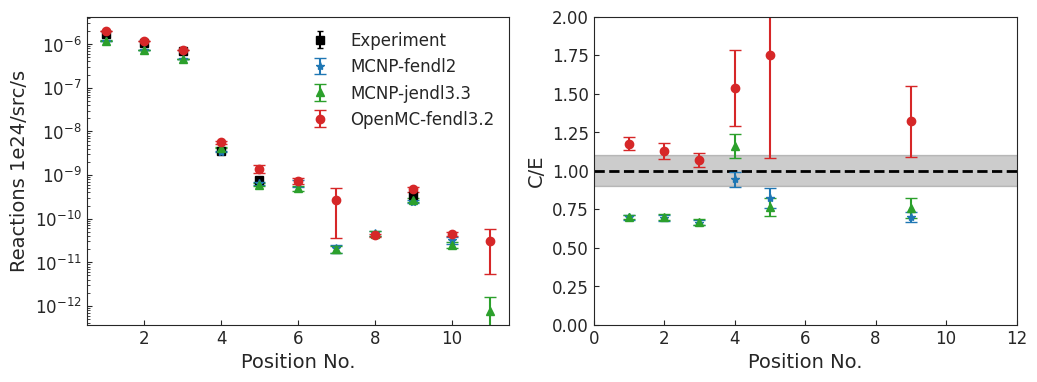

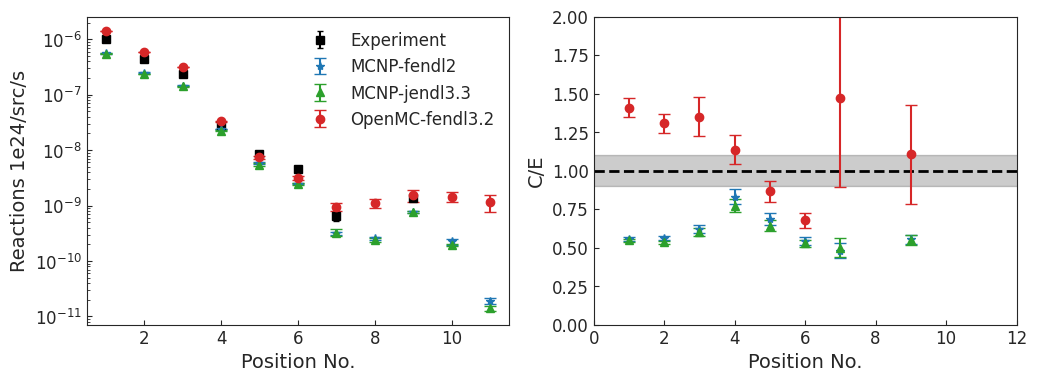

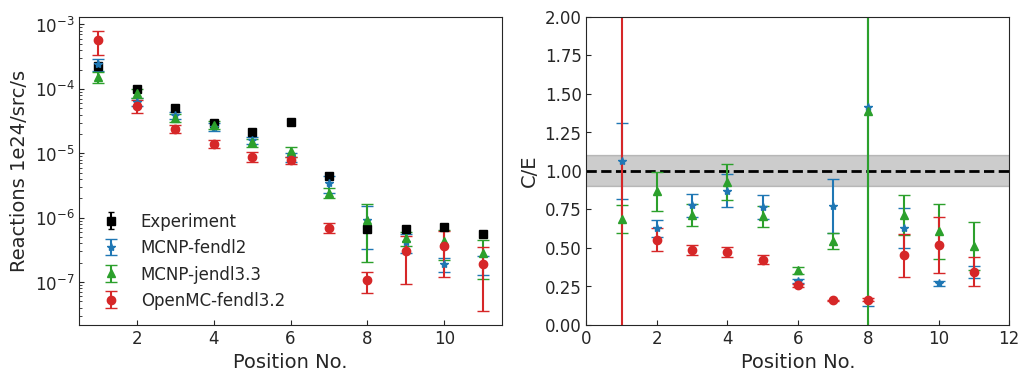

In [15]:
[plot_rr(nuclide) for nuclide in foil_nuclides]

### Neutron Energy Spectra

Energy spectra have been measured at detector positions:
- No.3: end of the first leg of the dogleg duct, same height of the source
- No.5: end of the second leg of the duct, the vertical one, lower position than the source
- No.7: end of the third leg of the duct, also end of the streaming assembly mockup, same height of #5
- No.9: behind the streaming assembly but at the same height of the source and spectrometer in position #3

See picture below:

<!-- <div>
<img src="" width="300"/>
</div> -->
![my_image](assembly_mockup.png)

Experimental and MCNP spectra results from previous benchmarks come with different energy group structures. We include both the group structures in our OpenMC simulations for good measure.

##### Experiment & MCNP spectra results

In [16]:
exp_spectra = pd.read_excel(filename_spectra, sheet_name='Measured')

sheetnames = ['Calc.（#3）', 'Calc.（#5）', 'Calc.（#7）', 'Calc.（#9）']
mcnp_fendl_spectra = []
mcnp_jendl_spectra = []
for sheet in sheetnames:
    mcnp_spectra = pd.read_excel(filename_spectra, sheet_name=sheet)
    fendl = mcnp_spectra[1:].drop(['jendl phi',	'jendl err', 'jendl over lethargy'], axis=1)
    jendl = mcnp_spectra[1:].drop(['fendl phi',	'fendl err', 'fendl over lethargy'], axis=1)
    mcnp_fendl_spectra.append(fendl)
    mcnp_jendl_spectra.append(jendl)

##### openMC energy spectra results

In [17]:
omc_spectra_exp = openmc.StatePoint(omc_spectra_sp).get_tally(name='detector_nspectrum2').get_pandas_dataframe()
omc_spectra_mcnp = openmc.StatePoint(omc_spectra_sp).get_tally(name='detector_nspectrum').get_pandas_dataframe()

##### Plot energy spectra results

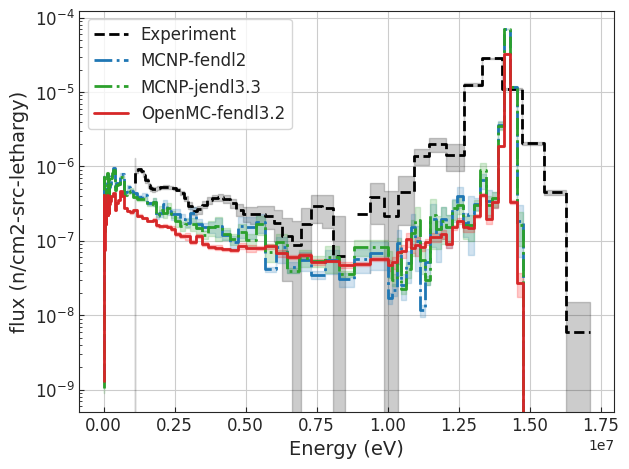

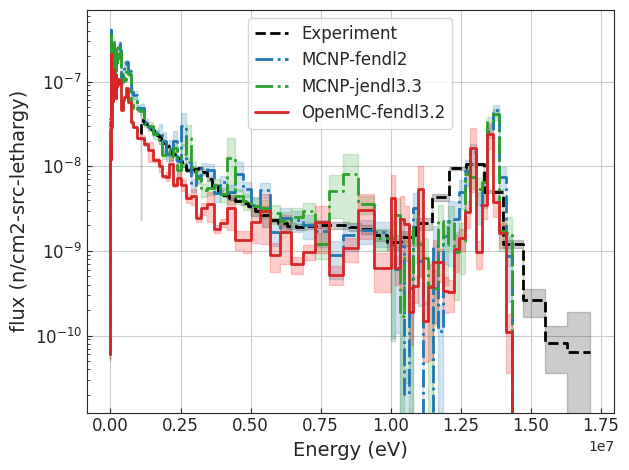

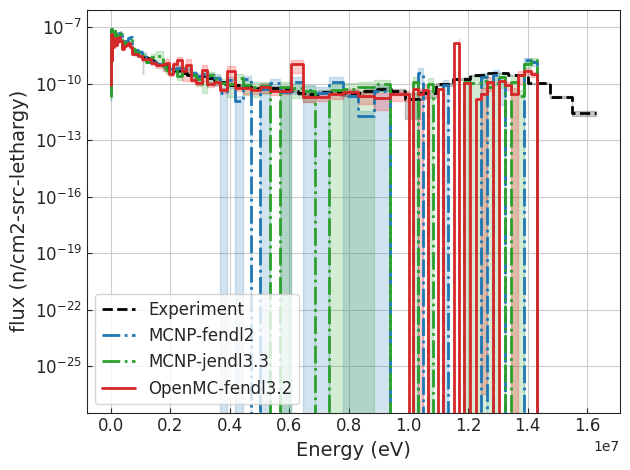

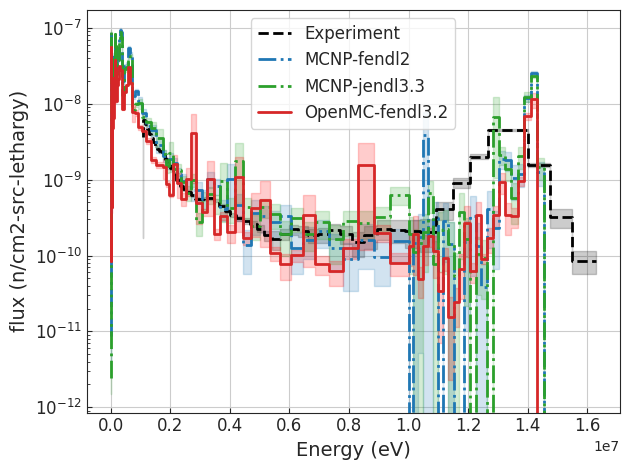

In [18]:
exp_mean_strings = ['S3(A) n_flux/lethargy/SN', 'L5(B) n_flux/lethargy/SN', 'L7(C)n_flux/lethargy/SN', 'L9(D)n_flux/lethargy/SN']
exp_error_strings = ['S3(A) erorr', 'L5(B) erorr', 'L7©erorr', 'L9(D)erorr']
spectrometer_cells = [303, 305, 307, 309]

for i,j in enumerate(spectrometer_cells):
    omc_nspectrum_df = omc_spectra_mcnp.loc[(omc_spectra_mcnp['cell'] == j)]
    lethargy = np.log(omc_nspectrum_df['energy high [eV]']/omc_nspectrum_df['energy low [eV]'])
    omc_nspectrum_mean = omc_nspectrum_df['mean'] / lethargy / foil_volume
    omc_nspectrum_error = omc_nspectrum_df['std. dev.'] / omc_nspectrum_df['mean']
    fig, ax = plt.subplots()
    ax.step(exp_spectra['Energy(MeV)']*1e6, exp_spectra[exp_mean_strings[i]], ls='dashed', lw=2, c='k', label='Experiment')
    ax.fill_between(exp_spectra['Energy(MeV)']*1e6, 
                    exp_spectra[exp_mean_strings[i]] * (1 - exp_spectra[exp_error_strings[i]]),
                    exp_spectra[exp_mean_strings[i]] * (1 + exp_spectra[exp_error_strings[i]]), 
                    step='pre', color='k', alpha=0.2)
    ax.step(mcnp_fendl_spectra[i]['energy']*1e6, mcnp_fendl_spectra[i]['fendl over lethargy'], ls='dashdot', lw=2, c='tab:blue', label='MCNP-fendl2')
    ax.fill_between(mcnp_fendl_spectra[i]['energy']*1e6, 
                    mcnp_fendl_spectra[i]['fendl over lethargy'] * (1 - mcnp_fendl_spectra[i]['fendl err']),
                    mcnp_fendl_spectra[i]['fendl over lethargy'] * (1 + mcnp_fendl_spectra[i]['fendl err']), 
                    step='pre', color='tab:blue', alpha=0.2)
    ax.step(mcnp_jendl_spectra[i]['energy']*1e6, mcnp_jendl_spectra[i]['jendl over lethargy'], ls='dashdot', lw=2, c='tab:green', label='MCNP-jendl3.3')
    ax.fill_between(mcnp_jendl_spectra[i]['energy']*1e6, 
                mcnp_jendl_spectra[i]['jendl over lethargy'] * (1 - mcnp_jendl_spectra[i]['jendl err']),
                mcnp_jendl_spectra[i]['jendl over lethargy'] * (1 + mcnp_jendl_spectra[i]['jendl err']), 
                step='pre', color='tab:green', alpha=0.2)
    ax.step(omc_nspectrum_df['energy high [eV]'], omc_nspectrum_mean, ls='solid', lw=2, c='tab:red', label='OpenMC-fendl3.2')
    ax.fill_between(omc_nspectrum_df['energy high [eV]'], 
                    omc_nspectrum_mean * (1 - omc_nspectrum_error),
                    omc_nspectrum_mean * (1 + omc_nspectrum_error), 
                    step='pre', color='red', alpha=0.2)
    ax.set_yscale('log')
    # ax.set_ylim([1e-9, 1e-4])
    ax.set_xlabel('Energy (eV)', fontsize=14)
    ax.set_ylabel('flux (n/cm2-src-lethargy)', fontsize=14)
    ax.tick_params(axis='both', which='both', direction='in', labelsize=12)
    ax.legend(fontsize=12)
    ax.grid()
    # plt.savefig('detector_3_nspectrum.png', format='png', dpi=600)
    fig.tight_layout()